In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax.scipy.stats.multivariate_normal import pdf as gaussian_pdf
from jax import jacfwd, jacrev
import optax
import numpy as np
import matplotlib.pyplot as plt

import pickle

from scipy.optimize import minimize
from scipy.integrate import solve_ivp

In [2]:
def M(x):
    @jit
    def lotka_volterra(t, state, x):
        alpha, beta = x
        delta = 0.1
        gamma = 0.4

        prey, predator = state[0], state[1]
        dprey_dt = alpha * prey - beta * prey * predator
        dpredator_dt = delta * prey * predator - gamma * predator
        return [dprey_dt, dpredator_dt]

    initial_state = [40, 9]
    t_eval = np.linspace(0, 300, 10000)
    solution = solve_ivp(lotka_volterra, [0, 300], initial_state, t_eval=t_eval, args=(x, ))

    return solution.y[:, 10::100]

x = [1.3, 0.4]
d_obs = M(x)+np.random.normal(0, 1, M(x).shape)

def updf(x):
    def likelihood(x):
        d = M(x)
        gap_d_dobs = np.linalg.norm(d-d_obs, 'fro')
        return gap_d_dobs

    def prior(x):
        if x[0] > 1.1 and x[0] < 2 and x[1] > 0.1 and x[1] < 1:
            return 1
        else:
            return 1e16

    x = jnp.array(x)
    value = likelihood(x) * prior(x)
    # value = jnp.where(value==0, 1e-16, value)
    return 1/value

# 2. MCMC

In [3]:
def RWMCMC(iter):
    x_curr = np.array([1.5, 0.3])
    x_set = []
    N = x_curr.shape[0]

    try:
        for i in range(1, iter):
            x_next = np.random.multivariate_normal(x_curr, 0.005*np.identity(N))
            if x_next[1]<=0:
                x_next[1] = 0.001

            alpha1 = updf(x_next)
            alpha2 = updf(x_curr)
            alpha = alpha1/alpha2
            alpha = np.min([1, alpha])
            x_curr = x_next if np.random.uniform(0, 1) < alpha else x_curr

            x_set.append(x_curr)
            print(len(x_set), alpha, x_curr.round(3))

        return x_set
    except KeyboardInterrupt:
        return x_set


def AMCMC(iter):
    x_curr = np.array([7, 15])
    N = x_curr.shape[0]
    x_set = []

    try:
        for i in range(0, iter):
            if i<=4:
                x_next = np.random.multivariate_normal(x_curr, 1*(np.identity(N)/2))
            else:
                COV = np.array(x_set)
                COV = np.cov(COV.T)
                x_next = (1-0.05)*np.random.multivariate_normal(x_curr, 2.38**2*COV/2) + 0.05*np.random.multivariate_normal(x_curr, 0.01*(np.identity(N)/2))

            alpha1 = updf(x_next)
            alpha2 = updf(x_curr)
            alpha = alpha1/alpha2
            alpha = np.min([1, alpha])
            x_curr = x_next if np.random.uniform(0, 1) < alpha else x_curr

            x_set.append(x_curr)
            print(len(x_set), alpha, x_curr.round(3))

        return x_set
    except KeyboardInterrupt:
        return x_set


def EMCEEMCMC(iter):
    x_curr = np.array([7, 15])
    N = x_curr.shape[0]
    x_set = []
    FS = np.random.uniform(-1, 1, (iter, N))

    try:
        for i in range(0, iter):
            full_range = np.arange(iter)
            left_range = full_range[full_range != i]
            x_next_index = np.random.choice(left_range)
            x_next = FS[x_next_index]

            z = ((1 + np.random.rand() * (2 - 1))**2) / 2
            x_next = x_next + z * (x_curr - x_next)

            alpha = jnp.power(z, N-1) * (updf(x_next)/ updf(x_curr))
            x_curr = x_next if np.random.uniform(0, 1) < alpha else x_curr

            x_set.append(x_curr)
            FS[i] = x_curr
            print(len(x_set), alpha, x_curr.round(3))
        return x_set
    except KeyboardInterrupt:
        return x_set

In [4]:
x_RWMCMC = RWMCMC(10000)
# x_AMCMC = AMCMC(10000)
# x_EMCEEMCMC = EMCEEMCMC(10000)

# np.save('/content/drive/MyDrive/No. 21 MCMC+TM/E3/Data_RMCMC.npy', x_RWMCMC)
# np.save('/content/drive/MyDrive/No. 21 MCMC+TM/E3/Data_AMCMC.npy', x_AMCMC)
# np.save('/content/drive/MyDrive/No. 21 MCMC+TM/E3/Data_EMCMC.npy', x_EMCEEMCMC)

1 0.6764106515204664 [1.5 0.3]
2 0.5446706146035855 [1.62  0.262]
3 0.9970459022418254 [1.672 0.308]
4 1.0 [1.696 0.419]
5 1.0 [1.784 0.478]
6 0.5846926204448406 [1.784 0.478]
7 0.5273713804023423 [1.784 0.478]
8 0.7620252748236666 [1.784 0.478]
9 0.9007266731754338 [1.768 0.517]
10 0.4636359636710182 [1.81  0.579]
11 1.0 [1.761 0.672]
12 1.0 [1.679 0.642]
13 1.0 [1.689 0.686]
14 0.6684342705125575 [1.763 0.667]
15 1.0 [1.7   0.695]
16 0.8881065625718694 [1.706 0.655]
17 0.2754454618729936 [1.645 0.728]
18 0.8375683727535087 [1.645 0.728]
19 1.0 [1.681 0.72 ]
20 0.9517660770257621 [1.65  0.674]
21 0.8339416483347011 [1.625 0.598]
22 0.7836093620812746 [1.563 0.511]
23 0.32085229036218305 [1.593 0.428]
24 1.0 [1.547 0.589]
25 1.0 [1.555 0.599]
26 0.2997063102931978 [1.555 0.599]
27 0.34693943360994495 [1.555 0.599]
28 0.6693112884573604 [1.716 0.676]
29 1.0 [1.703 0.706]
30 0.3696358682157912 [1.703 0.706]
31 0.9542341193132037 [1.734 0.687]
32 0.44896838207904666 [1.71  0.577]
33 1.0 [

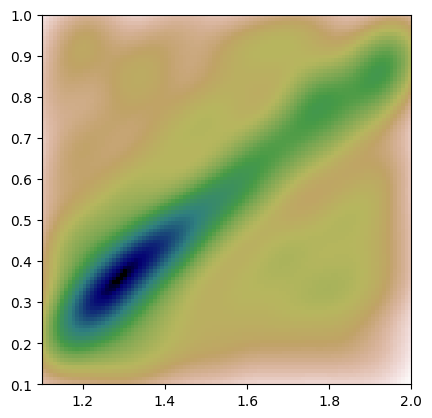

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

x_RWMCMC = np.array(x_RWMCMC)

# 提取 x 和 y 数据
x = x_RWMCMC[:, 0]
y = x_RWMCMC[:, 1]

# 使用 gaussian_kde 进行核密度估计
kde = gaussian_kde([x, y])

# 创建网格点
xmin, xmax = 1.1, 2
ymin, ymax = 0.1, 1
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])

# 计算每个网格点的密度值
Z = np.reshape(kde(positions).T, X.shape)

# 绘制结果
fig, ax = plt.subplots()
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax])
plt.show()